# UEP-0239 Homework Assignment 7

In this assignment we will practice raster analysis by conducting a risk assessment, which has a workflow nearly identical to a suitability analysis. The assignment is largely based on [this tutorial](https://sites.tufts.edu/gis/files/2013/11/RiskAssessment_MalariaInEthiopia_tutorial_10.6.1.pdf) written by Carolyn Talmadge for the [Tufts Data Lab](https://sites.tufts.edu/datalab/). The tutorial walks through a similar analysis using ArcGIS Desktop (also known as ArcMap). Your mission is to translate parts of the analysis into Python code utilizing open-source libraries as instructed below.

## Introduction

Malaria is a serious acute illness transmitted via the bite of a mosquito. Symptoms include fever, headache, backache, joint pains, and vomiting. If not treated, malaria can quickly become life-threatening. According to the World Health Organization (WHO), roughly 75% of the land and 60% of the population is exposed to malaria in Ethiopia. The purpose of this analysis is to determine the overall risk of Malaria transmission throughout Ethiopia, considering the following factors:

- **Proximity to rivers** – Malaria is a water-related disease because it is transmitted via mosquitos who prefer to breed near rivers. Therefore, proximity to rivers results in higher risk of transmission.
- **Elevation** – Elevation is directly linked to climate, and mosquitos prefer warmer climates and lower elevations. Lower elevations increase mosquito population turnover, which means a higher risk of transmission.
- **Slope** – Gentle slopes equal higher susceptible areas for malaria incidence.
- **Land cover** – Mosquitos prefer damp areas, so land cover will affect the analysis.

## The Data

The `data` folder in your assignment repository should contain the following files:

- `data/boundaries/ethiopia.shp` – the boundaries of Ethiopia (ESRI shapefile)
- `data/boundaries/zones.shp` – boundaries of second-order administrative zones (ESRI shapefile)
- `data/elevation/elevation.tif` - digital elevation model (DEM) of Ethiopia and surrounding areas (GeoTIFF)
- `data/landcover/landcover.tif` - land cover raster for Ethiopia and surrounding areas (GeoTiFF)
- `data/water/rivers.shp` – rivers of Ethiopia (ESRI Shapefile)

To make your analysis simpler, the `elevation.tif` and `landcover.tif` rasters have been clipped to the same extent with matching resolutions and all data has been projected to the [ESRI:102022 Africa Alberts Equal Area Conic](https://spatialreference.org/ref/esri/africa-albers-equal-area-conic/) projection.

## Analysis Overview

Here is a rough outline of the analysis we will perform:

1. Read in and visualize the raster datasets (10 pts)
2. **Land cover** > reclassify for land cover preferences (10 pts)
3. **Elevation (DEM)** > derive slope > reclassify for slope preferences (low slope = high risk) (20 pts)
4. **Elevation (DEM)** > reclassify for elevation preferences (low elevation = high risk) (10 pts)
5. **Rivers** > rasterize shapefile > get euclidean distance raster > reclassify (close = high risk) (25 pts)
6. Calculate weighted and unweighted risk raster from all reclassified rasters (5 pts)
7. Mask risk rasters to the shape of Ethiopia (10 pts)
8. **Extra credit:** Use zonal statistics to determine average risk per zone (20 pts)


## Import Dependencies

Here are some dependency imports to get you started. Feel free to add more import statements if needed.

In [314]:
import rasterio
from rasterio.plot import show
from rasterio import features

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats

In [315]:
import folium
import osmnx as ox
import networkx as nx
from geopy.geocoders import Nominatim

## Read Raster Datasets (5 pts)

Use [`rasterio.open()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.html#rasterio.open) to open and read in both the elevation and landcover datasets. Remember that just like the [`open()`](https://docs.python.org/3/library/functions.html#open) function in Python, this function establishes a connection to the file, which should later be closed. Hence, you should either use [`with`](https://docs.python.org/3/reference/compound_stmts.html#with) to open the file and extract all relevant information or make sure to use [`.close()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.close) to close the connection once you are done.

It is also important to remember that the [`rasterio.open()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.html#rasterio.open) function returns a [`DatasetReader`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader) object, not the dataset itself. However, the [`DatasetReader`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader) object has numerous attributes and methods that allow you to read in various components of the raster dataset. For example, you can use the [`.meta`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.meta) attribute to access the metadata associated with the raster and you can use the [`.read()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.read) method to extract the raster data values as a matrix.

Both raster datasets should have the same coordinate system, extent, and resolution, but you should use the [`.meta`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.meta) attribute to compare the metadata for both files and ensure this is the case.

Once you have confirmed that the spatial attributes of both rasters are the same, use the [`.read()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.read) method with the appropriate band number to save the data matrices of the raster datasets into variables named `elevation` and `landcover`. Then pick one raster and use the appropriate attributes to extract all necessary spatial information into corresponding variables as well. Here is the information that is vital to the analysis:

- [`bounds`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.bounds) – the spatial extent of the rasters
- [`crs`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.crs) – the coordinate system used
- [`nodata`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.nodata) – the nodata value used (do this for each raster if the nodata values do not match)
- [`shape`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.shape) – number of rows and columns
- [`transform`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.transform) – how to translate from row/column indices to spatial coordinates

Make sure to explore both the data matrices and the various metadata values once you have extracted them to ensure everything is as expected.

In [316]:
#Use rasterio.open() to open and read in both the elevation and landcover datasets. First, elevation:
elevationfile = rasterio.open('\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\hw07-finashort\\data\\elevation\\elevation.tif')

#use the .read() method with the appropriate band number to save the data matrices of the raster datasets into variables named elevation and landcover.
elevation = elevationfile.read(1)
#there is only one band so this works

In [317]:
#explore it
elevationfile.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 1557,
 'height': 1336,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["Africa_Albers_Equal_Area_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",25],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",-23],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(1000.0, 0.0, 832212.046055039,
        0.0, -1000.0, 1734510.2316801762)}

In [318]:
#Then pick one raster and use the appropriate attributes to extract all necessary spatial information into corresponding variables as well. 
elevationshape=elevation.shape
elevationbounds=elevationfile.bounds
elevationcrs=elevationfile.crs
elevationtransform=elevationfile.transform
elevation_nodata=elevationfile.nodata
elevationres=elevationfile.res
#make sure these worked
print(elevationshape)
print(elevationbounds)
print(elevationcrs)

(1336, 1557)
BoundingBox(left=832212.046055039, bottom=398510.2316801762, right=2389212.046055039, top=1734510.2316801762)
PROJCS["Africa_Albers_Equal_Area_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",25],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",-23],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [319]:
#done using elevation file
elevationfile.close()

In [320]:
#next, landcover
landcoverfile = rasterio.open('\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\hw07-finashort\\data\\landcover\\landcover.tif')
#now some exploration
print(landcoverfile.shape)
print(landcoverfile.crs)

#use the .read() method with the appropriate band number to save the data matrices of the raster datasets into variables named elevation and landcover.
landcover = landcoverfile.read(1)
landcover

(1336, 1557)
PROJCS["Africa_Albers_Equal_Area_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",25],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",-23],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


array([[10,  7,  9, ..., 16,  7, 16],
       [10,  6,  7, ..., 16, 16, 16],
       [ 7, 16, 10, ...,  7, 16, 16],
       ...,
       [ 8, 10,  8, ...,  0,  0,  0],
       [ 8, 10,  8, ...,  0,  0,  0],
       [10,  9,  8, ...,  0,  0,  0]], dtype=int16)

In [321]:
#check with boolean statements to make sure certain variables in the rasters are the same
elevationtransform==landcoverfile.transform

True

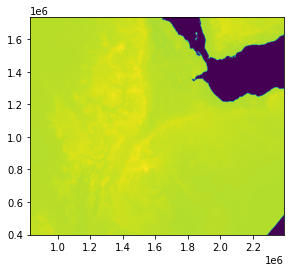

In [322]:
show(elevation, transform=elevationtransform)
plt.show()

In [323]:
#done using landcover file
landcoverfile.close()

## Visualize the Raster Datasets (5 pts)

Use the RasterIO [`show()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.show) function to visualize both raster datasets and ensure they were read in correctly. Make sure to specify the `transform` to see actual spatial coordinates on the axes. Also use the `cmap` attribute to specify appropriate [Matplotlib colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for each dataset. Remember that land cover data is categorical, so you should use a categorical color map for that visualization.

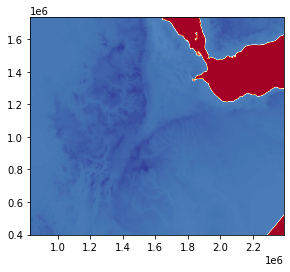

In [324]:
#use rasterIO show() to visualize elevation raster dataset
elevationplot = show(elevation, transform=elevationfile.transform, cmap='RdYlBu') #using transform to see spatial coords on axes
#elevationplot.set_title("Visualized Elevation Raster Dataset", fontsize=10)
plt.show()

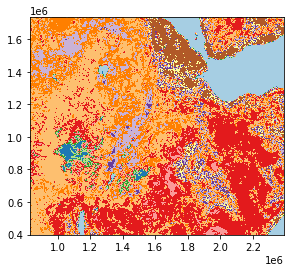

In [325]:
#plotting land cover raster using show function
landplot = show(landcover, transform=landcoverfile.transform, cmap='Paired') #using "Paired" color map for categorical data

In both visuals, the axes display values such that we can see actual spatial coordinates. I know that this visualization is correct because the axes match the "right" and "top" values I got from the .bound function (right=2389212.046055039, top=1734510.2316801762).

## Reclassify Land Cover (10 pts)

Although the land cover raster contains numeric data, each number is representative of a land cover type. This information is usually stored in the raster attribute table accompanying the raster. The land cover raster we are using also has an accompanying raster attribute table, but unfortunately RasterIO is not yet able to read raster attribute tables. Hence, you have to use the table below to map the numerical cell values to their corresponding land cover types.

| Cell Value | Land Cover                       |
| :--------: | -------------------------------- |
|      0     | Water                            |
|      1     | Evergreen Needleleaf Forest      |
|      2     | Evergreen Broadleaf Forest       |
|      3     | Deciduous Needleleaf Forest      |
|      4     | Deciduous Broadleaf Forest       |
|      5     | Mixed Forests                    |
|      6     | Closed Shrublands                |
|      7     | Open Shrublands                  |
|      8     | Woody Savannas                   |
|      9     | Savannas                         |
|     10     | Grasslands                       |
|     11     | Permanent Wetlands               |
|     12     | Croplands                        |
|     13     | Urban and Built-Up Areas         |
|     14     | Cropland with Natural Vegetation |
|     15     | Snow and Ice                     |
|     16     | Barren or Sparsely Vegetated     |


We would like to assign a risk score ranging from one to five (with one denoting lowest risk and five denoting highest risk) to each of the land cover types as specified below.

| Land Cover Types                     | Land Cover Codes  | Risk Level     | Risk Score |
| ------------------------------------ | ----------------- | -------------- | :--------: |
| Water and Wetlands                   | 0, 11             | Very high risk |      5     |
| Croplands and Natural Vegetation     | 12, 14            | High risk      |      4     |
| Shrublands, Grasslands, and Savannas | 6, 7, 8, 9, 10    | Medium risk    |      3     |
| Forests and Urban/Built-Up Areas     | 1, 2, 3, 4, 5, 13 | Low risk       |      2     |
| Snow/Ice and Barren Land             | 15, 16            | Very low risk  |      1     |


Create a reclassified land cover raster as follows:
1. Use [`np.full()`](https://numpy.org/doc/stable/reference/generated/numpy.full.html) to create an empty array filled with `np.NaN` that matches the `shape` of the land cover raster.
2. Utilize [boolean indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#boolean-array-indexing) to fill the newly created raster based on values of the `landcover` data matrix.

Once you have created the reclassified land cover raster, visualize it with using the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap.

In [326]:
#1) use np.full() to create the empty array fillwed with np.NaN to match shape of land cover raster
lcshape = landcover.shape #storing shape
#creating empty array
lcreclass = np.full(lcshape, np.NaN)
#view my new array and check that shape has remained correct/ matching land cover raster
print(lcreclass.shape==lcshape)
lcreclass

True


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [327]:
#2) use boolean indexing to fill new raster based on landcover data matrix

lcreclass[(landcover == 15) | (landcover ==16)] = 1
lcreclass[(landcover == 1) | (landcover ==2) | (landcover==3) | (landcover==4) | (landcover==5) | (landcover==13)] = 2
lcreclass[(landcover == 6) | (landcover ==7) | (landcover==8) | (landcover==9) | (landcover==10)] = 3
lcreclass[(landcover == 12) | (landcover ==14)] = 4
lcreclass[(landcover == 0) | (landcover ==11)] = 5
lcreclass

array([[3., 3., 3., ..., 1., 3., 1.],
       [3., 3., 3., ..., 1., 1., 1.],
       [3., 1., 3., ..., 3., 1., 1.],
       ...,
       [3., 3., 3., ..., 5., 5., 5.],
       [3., 3., 3., ..., 5., 5., 5.],
       [3., 3., 3., ..., 5., 5., 5.]])

## Calculate Slope Raster (10 pts)

Use [RichDEM](https://richdem.readthedocs.io/en/latest/) to calculate a slope raster as follows:
1. Use `rd.rdarray()` to create an `rdarray` version of the `elevation` matrix. Make sure to specify the appropriate `no_data` value!
2. Use `.to_gdal()` to convert the `transform` to the format expected by RichDEM and set that as the `.geotransform` attribute of the new `rdarray`.
3. Use [`rd.TerrainAttribute()`](https://richdem.readthedocs.io/en/latest/python_api.html#richdem.TerrainAttribute) to calculate the `"slope_percentage"` attribute.

Note that the values of the result matrix are slope percentages, meaning that they range from zero to one hundred. Make sure to take a look at the data matrix and visualize it using [`show()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.show) to validate your work.

In [328]:
#1 use rd.rdarray() to create rdarray version of elevation matrix, specifying appropriate no data value
elevation_rd = rd.rdarray(elevation, no_data=elevation_nodata)

In [329]:
#2 use .to_gdal() to convert transform to format expected by richdem, set that as geotransform attribute
elevation_rd.geotransform = elevationtransform.to_gdal()
slope = rd.TerrainAttribute(elevation_rd, attrib = 'slope_percentage')

In [330]:
slope

rdarray([[ 2.1213204e-01,  1.6007811e-01,  3.6912057e-01, ...,
           1.8915932e+00,  1.5366360e+00,  1.6554834e+00],
         [ 3.9528470e-02,  2.7669930e-01,  2.7950850e-01, ...,
           1.7201926e+00,  1.7804494e+00,  2.1396554e+00],
         [ 4.5069391e-01,  2.6925823e-01,  2.2150056e-01, ...,
           4.0630193e+00,  4.8939376e+00,  4.1506400e+00],
         ...,
         [ 1.0700468e+00,  6.6918796e-01,  3.7500000e-01, ...,
          -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
         [ 4.8088461e-01,  7.1959192e-01,  8.7927526e-01, ...,
          -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
         [ 1.3550830e+00,  1.0125772e+00,  6.5693414e-01, ...,
          -9.9990000e+03, -9.9990000e+03, -9.9990000e+03]], dtype=float32)

In [331]:
#reclassing slope raster
slopereclass[(slope < 0.02)] = 5
###
slopereclass[(slope >= 0.02) & (slope <0.05)] = 4
slopereclass[(slope >= 0.05) & (slope <0.12)] = 3
slopereclass[(slope >= 0.12) & (slope <0.2)] = 2
slopereclass[(slope >=0.2)] = 1


slopereclass

array([[1., 2., 1., ..., 1., 1., 1.],
       [4., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 5., 5., 5.],
       [1., 1., 1., ..., 5., 5., 5.],
       [1., 1., 1., ..., 5., 5., 5.]])

## Reclassify Slope Raster (10 pts)

Create a reclassified slope raster as follows:
1. Use [`np.full()`](https://numpy.org/doc/stable/reference/generated/numpy.full.html) to create an empty array filled with `np.NaN` that matches the `shape` of the slope raster.
2. Utilize [boolean indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#boolean-array-indexing) to fill the newly created raster based on the following slope values.

| Min Slope (Inclusive) | Max Slope (Exclusive) |   Risk Level   | Risk Score |
| :-------------------: | :-------------------: | :------------: | :--------: |
|          ...          |           2%          | Very high risk |      5     |
|           2%          |           5%          |    High risk   |      4     |
|           5%          |          12%          |   Medium risk  |      3     |
|          12%          |          20%          |    Low risk    |      2     |
|          20%          |          ...          |  Very low risk |      1     |


Note that you will be repeating a similar workflow to reclassify other rasters numerous times. If you are up for the challenge, attempt to write a function for the reclassification procedure that will allow you to automate further reclassification attempts. Once you have created the reclassified slope raster, visualize it with using the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap.

In [332]:
#1) use np.full() to create the empty array fillwed with np.NaN to match shape of slope raster
slopeshape = elevation.shape #storing shape
#creating empty array
slopereclass = np.full(slopeshape, np.NaN)
#view my new array and check that shape has remained correct/ matching land cover raster
print(slopereclass.shape==slopeshape)
slopereclass

True


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [333]:
#use boolean indexing to fill the newly created raster
#2) use boolean indexing to fill new raster based on slope data matrix

#reclassing slope raster
slopereclass[(slope < 0.02)] = 5
###
slopereclass[(slope >= 0.02) & (slope <0.05)] = 4
slopereclass[(slope >= 0.05) & (slope <0.12)] = 3
slopereclass[(slope >= 0.12) & (slope <0.2)] = 2
slopereclass[(slope >=0.2)] = 1


slopereclass

array([[1., 2., 1., ..., 1., 1., 1.],
       [4., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 5., 5., 5.],
       [1., 1., 1., ..., 5., 5., 5.],
       [1., 1., 1., ..., 5., 5., 5.]])

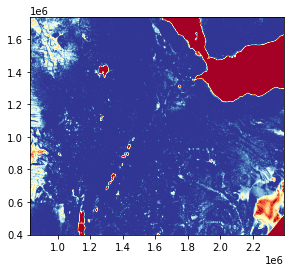

In [334]:
#visualize it reclassified
landplot = show(slopereclass, transform=elevationtransform, cmap='RdYlBu_r') 

## Reclassify Elevation Raster (10 pts)

Create a reclassified elevation raster based on the following elevation values.

| Min Elevation (Inclusive) | Max Elevation (Exclusive) |   Risk Level   | Risk Score |
| :-----------------------: | :-----------------------: | :------------: | :--------: |
|            ...            |             0             | Very high risk |      5     |
|             0             |            500            |    High risk   |      4     |
|            500            |            1200           |   Medium risk  |      3     |
|            1200           |            3000           |    Low risk    |      2     |
|            3000           |            ...            |  Very low risk |      1     |


Once you have created the reclassified land elevation raster, visualize it with using the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap.

In [335]:
elevreclass = np.full(slopeshape, np.NaN)
elevreclass[(elevation < 0)] = 5
elevreclass[(elevation >= 0) & (elevation >500)] = 4
elevreclass[(elevation >= 500) & (elevation >1200)] = 3
elevreclass[(elevation >= 1200) & (elevation >3000)] = 2
elevreclass[(elevation >= 3000)] = 1
elevreclass

array([[nan, nan, nan, ...,  3.,  3.,  3.],
       [nan, nan, nan, ...,  3.,  3.,  3.],
       [nan, nan, nan, ...,  3.,  3.,  3.],
       ...,
       [ 4.,  4.,  4., ...,  5.,  5.,  5.],
       [ 4.,  4.,  4., ...,  5.,  5.,  5.],
       [ 4.,  4.,  4., ...,  5.,  5.,  5.]])

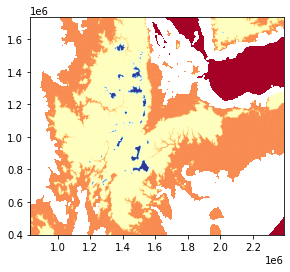

<AxesSubplot:>

In [336]:
elevplot = show(elevreclass, transform=elevationtransform, cmap='RdYlBu_r') 
elevplot

## Read in and Rasterize River Shapefile (10 pts)

We could like to consider distance to rivers in our analysis. To do so, we must first calculate an euclidean distance raster where the value of each cell is the distance to the nearest river from that cell. To do so, we must first read in and rasterize the river shapefile as follows:

1. Use [`gpd.read_file()`](https://geopandas.org/docs/reference/api/geopandas.read_file.html#geopandas.read_file) to read in the rivers shapefile.
2. Use [`features.rasterize()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.rasterize) from RasterIO to convert the river shapefile into a binary raster where zero denotes a river and one denotes the lack of a river.
    - Note that you should use the `"geometry"` column from the rivers GeoDataFrame as input.
    - Remember to specify the appropriate `transform`.
    - Use `default_value` to specify the value that should denote the presence of a river (0).
    - Use `fill` to specify the value that should denote the lack of a river (1).
    
Visualize both the shapefile and the raster to make sure the conversion worked as expected. If you have a hard time seeing the river pixels of the raster, use the `"flag"` colormap to bring them out more.

In [337]:
#1) use gpd.read_file to read in the rivers shapefile
rivers=gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\hw07-finashort\\data\\water\\rivers.shp")
rivers.head(8) #take a look at dataset

,osm_id,name,type,width,geometry
0,8036035,None,river,0,"LINESTRING (1150575.121 570853.647, 1150805.67..."
1,22763801,None,river,0,"LINESTRING (1449789.612 944897.478, 1450003.59..."
2,23409657,None,stream,0,"LINESTRING (1727520.584 1296850.102, 1727558.8..."
3,24259902,None,river,0,"LINESTRING (1441193.600 1051699.417, 1441189.4..."
4,24299073,Kebena,river,0,"LINESTRING (1434262.166 1057608.628, 1434257.2..."
5,24299082,None,river,0,"LINESTRING (1434069.583 1063348.342, 1434097.4..."
6,24299092,None,river,0,"LINESTRING (1437043.206 1068426.066, 1437035.7..."
7,24491181,None,river,0,"LINESTRING (1428343.896 1061831.149, 1428331.2..."


In [338]:
riversshape=rivers.shape
riverstransform=rivers.transform
riverstransform

<bound method DataFrame.transform of          osm_id    name    type  width  \
0       8036035    None   river      0   
1      22763801    None   river      0   
2      23409657    None  stream      0   
3      24259902    None   river      0   
4      24299073  Kebena   river      0   
...         ...     ...     ...    ...   
1949  297796803    None   canal      0   
1950  299167797    None  stream      0   
1951  299167798    None  stream      0   
1952  299167800    None  stream      0   
1953  301483976    None  stream      0   

                                               geometry  
0     LINESTRING (1150575.121 570853.647, 1150805.67...  
1     LINESTRING (1449789.612 944897.478, 1450003.59...  
2     LINESTRING (1727520.584 1296850.102, 1727558.8...  
3     LINESTRING (1441193.600 1051699.417, 1441189.4...  
4     LINESTRING (1434262.166 1057608.628, 1434257.2...  
...                                                 ...  
1949  LINESTRING (1667663.377 1373103.381, 1666790.3

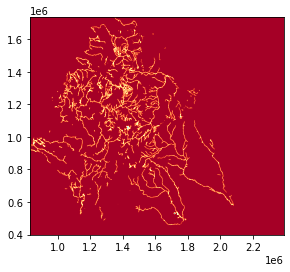

<AxesSubplot:>

In [339]:
#using shape of the slope raster
rivers_raster = features.rasterize(rivers['geometry'], out_shape=slopeshape, fill=1, transform=elevationtransform, default_value=0)
show(rivers_raster, transform=elevationtransform, cmap='RdYlBu_r') 

## Calculate Euclidean Distance Raster (5 pts)

Now we are ready to create an euclidean distance matrix that denotes distances to the nearest river. This is a relatively simple two-step process:
1. Use [`ndimage.distance_transform_edt()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html) from SciPy to calculate the euclidean distance transform for the binary rivers raster.
2. Multiply the distance transform raster with the raster cell size (width or length) to convert the distances from number of cells to spatial units.
    - The `res` attribute you saved earlier should contain the dimensions of the square raster cell.
    
Note that this workflow assumes the raster to have square cells, which is the case for us. Once completed, visualize the distance raster to validate your work.

In [340]:
rivertrans = ndimage.distance_transform_edt(rivers_raster) * elevationres[0]
rivertrans #looking at resulting array

array([[377041.11181674, 376288.45318452, 375536.94891448, ...,
        682589.9208163 , 683344.71535236, 684100.13886857],
       [376384.11231081, 375630.13723608, 374877.31326395, ...,
        681934.01440315, 682689.53412221, 683445.68182117],
       [375728.62547323, 374973.33238512, 374219.1871083 , ...,
        681278.94433925, 682035.18970798, 682792.0620511 ],
       ...,
       [331850.8701209 , 330925.9735953 , 330001.51514804, ...,
        354870.39887824, 355735.85706251, 356602.01906327],
       [332231.84675765, 331308.01378777, 330384.62433957, ...,
        355373.04343464, 356237.28047469, 357102.22626021],
       [332615.39351028, 331692.62879962, 330770.31305726, ...,
        355877.78801156, 356740.80226405, 357604.53017265]])

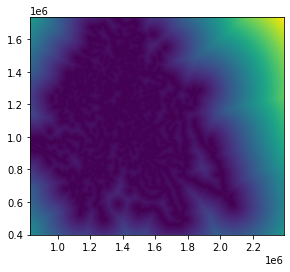

<AxesSubplot:>

In [341]:
#visualize it to validate work
show(rivertrans, transform=elevationtransform)

## Reclassify Distance Raster (10 pts)

Create a reclassified river distance raster based on the following distance values. Remember that the distance values are in meters!

| Min Distance (Inclusive) | Max Distance (Exclusive) |   Risk Level   | Risk Score |
| :----------------------: | :----------------------: | :------------: | :--------: |
|            ...           |      1 mile (1609 m)     | Very high risk |      5     |
|      1 mile (1609 m)     |     5 miles (8046 m)     |    High risk   |      4     |
|     5 miles (8046 m)     |    25 miles (40233 m)    |   Medium risk  |      3     |
|    25 miles (40233 m)    |    75 miles (120701 m)   |    Low risk    |      2     |
|    75 miles (120701 m)   |            ...           |  Very low risk |      1     |


Once you have created the reclassified distance raster, visualize it using the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap.

In [342]:
riversreclass = np.full(slopeshape, np.NaN) #using slope shape to reclass
riversreclass[rivertrans < 1609] = 5
riversreclass[(rivertrans >= 1609) & (rivertrans <= 8046)] = 4
riversreclass[(rivertrans > 8046) & (rivertrans <= 40233)] = 3
riversreclass[(rivertrans > 40233) & (rivertrans <= 120701)] = 2
riversreclass[rivertrans > 120701] = 1

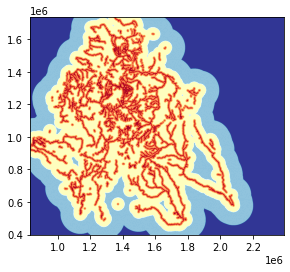

<AxesSubplot:>

In [343]:
show(riversreclass, transform=elevationtransform, cmap='RdYlBu_r') #matching the transform to elevation raster

## Calculate Weighted and Unweighted Risk Rasters (5 pts)

Create and visualize both a weighted and an unweighted risk raster. For the unweighed risk raster, just add up all the reclassified rasters. For the weighted risk raster, assign the following weights to each component.

| Component          | Weight |
| ------------------ | :----: |
| Distance to rivers |   35%  |
| Land cover         |   25%  |
| Slope              |   25%  |
| Elevation          |   15%  |

When visualizing the rasters, use the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap as before.

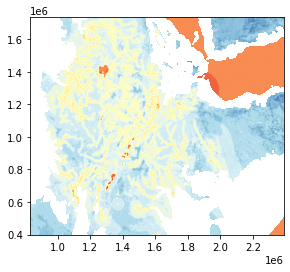

<AxesSubplot:>

In [344]:
#unweighted risk raster
uw_suitability = lcreclass + elevreclass + slopereclass + riversreclass
show(uw_suitability, transform=elevationtransform, cmap='RdYlBu_r')

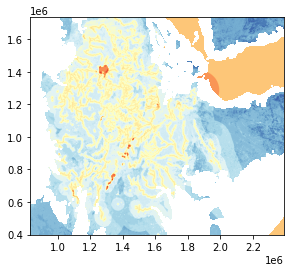

<AxesSubplot:>

In [345]:
#weighted risk raster
w_suitability = lcreclass*(0.25) + elevreclass*(0.15) + slopereclass*(0.25) + riversreclass*(0.35)
show(w_suitability, transform=elevationtransform, cmap='RdYlBu_r')

## Mask the Risk Rasters (10 pts)

Because the rivers shapefile was confined to the boundaries of Ethiopia and the elevation DEM contained some missing data outside of the boundaries of Ethiopia, our risk rasters only have accurate values within the boundaries of Ethiopia. Hence we should mask the risk rasters to the boundaries of Ethiopia by marking all cells outside of Ethiopia as `np.NaN` to denote no data. This can be done as follows:

1. Use [`gpd.read_file()`](https://geopandas.org/docs/reference/api/geopandas.read_file.html#geopandas.read_file) to read in the boundaries of Ethiopia.
2. Use [`features.rasterize()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.rasterize) from RasterIO to convert the Ethiopia shapefile into a binary raster.
3. Use [boolean indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#boolean-array-indexing) to replace all cells in the risk rasters that are not within Ethiopia with `np.NaN`.

Once you have masked the risk rasters, visualize them again using the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap.

In [346]:
ethiopia=gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\hw07-finashort\\data\\boundaries\\ethiopia.shp")
ethiopia.head #one single polygon
eth_shape=ethiopia.shape
eth_trans=ethiopia.transform

In [347]:
ethiopia #looking at shapefile

,NAME_0,geometry
0,Ethiopia,"POLYGON ((1351498.273 1732503.901, 1352014.052..."


In [348]:
#use features rasterize to convert into binary raster, making it the size and shape of my other rasters
ethiopiaraster = features.rasterize(ethiopia['geometry'], out_shape=elevationshape, fill=1, transform=elevationtransform, default_value=0) #0=within bounds

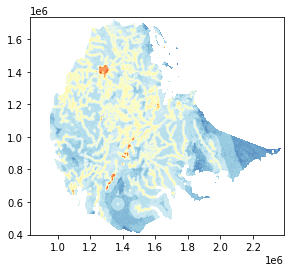

<AxesSubplot:>

In [349]:
#use boolean indexing to replace cells in risk rasters not in ethiopa w/ np.Nan
#set up boolean index for ethiopia raster
not_ethiopia_value = np.where(ethiopiaraster==1, np.NaN, w_suitability)
show(not_ethiopia_value, transform=elevationtransform, cmap='RdYlBu_r')

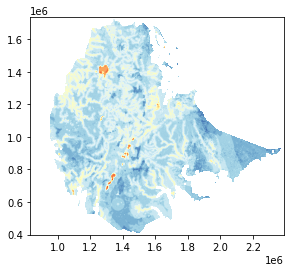

<AxesSubplot:>

In [350]:
#next, unweighted suitability raster
not_ethiopia_value2 = np.where(ethiopiaraster==1, np.NaN, uw_suitability)
show(not_ethiopia_value2, transform=elevationtransform, cmap='RdYlBu_r')